In [1]:
%autoreload 2

In [14]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)


from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn import cluster
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdmn
from sklearn.decomposition import PCA
import umap


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer
from src.fitness_features_preprocessing import NGRAM_SCORE_PATTERN
from src import latest_model_paths
from src.fitness_features import *

In [4]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))

# regrown_game_asts = list(cached_load_and_parse_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl', grammar_parser, True, relative_path='..'))



In [5]:
def _load_pickle_gzip(path: str):
    with gzip.open(path, 'rb') as f:
        return pickle.load(f)


latest_fitness_feauturizer = _load_pickle_gzip(latest_model_paths.LATEST_FITNESS_FEATURIZER_PATH)
latest_model, latest_feature_names = utils.load_model_and_feature_columns(latest_model_paths.LATEST_FITNESS_FUNCTION_DATE_ID)

In [6]:
def games_to_arrays(games, featurizer: ASTFitnessFeaturizer, feature_names: typing.List[str]):
    feature_dicts = []
    features = []
    for game in games:
        game_features = featurizer.parse(game, return_row=True)
        feature_dicts.append(game_features)
        features.append([game_features[name] for name in feature_names])  # type: ignore
    
    return feature_dicts, np.array(features)


feature_dicts, features_array = games_to_arrays(game_asts, latest_fitness_feauturizer, latest_feature_names)
features_array.shape



(98, 352)

0.9826191749155214


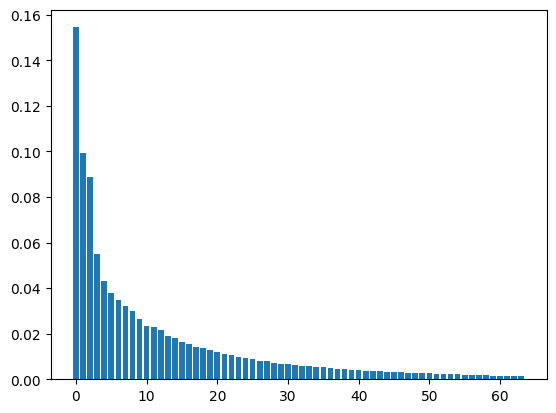

In [18]:
N_PCA_COMPONENTS = 64
PCA_RANDOM_SEED = 33

pca = PCA(n_components=N_PCA_COMPONENTS, random_state=PCA_RANDOM_SEED)
features_pca = pca.fit_transform(features_array)
plt.bar(np.arange(N_PCA_COMPONENTS), pca.explained_variance_ratio_[:N_PCA_COMPONENTS])
print(pca.explained_variance_ratio_.sum())

In [19]:
aff_prop = cluster.AffinityPropagation().fit(features_pca)
aff_prop.cluster_centers_indices_

array([ 1,  9, 16, 23, 47, 63, 73, 75, 76, 78, 83])

In [20]:
N_TOP_COMPONENTS = 10
N_TOP_FEATURES = 5

for i in range(N_TOP_COMPONENTS):
    comp = np.abs(pca.components_[i])
    top_indices = np.argpartition(comp, -N_TOP_FEATURES)[-N_TOP_FEATURES:][::-1]
    top_features = [latest_feature_names[i] for i in top_indices]
    top_features_str = ', '.join([f'{f} = {pca.components_[i][idx]:.3f}' for idx, f in zip(top_indices, top_features)])
    print(f'Component {i + 1}: {top_features_str}')




Component 1: max_depth_setup_0 = 0.199, section_doesnt_exist_setup = 0.199, mean_depth_setup_0 = 0.199, node_count_setup_0 = 0.199, ast_ngram_setup_n_5_score = -0.195
Component 2: mean_depth_terminal_0 = -0.263, section_doesnt_exist_terminal = -0.263, node_count_terminal_0 = -0.263, max_depth_terminal_0 = -0.263, max_depth_terminal_2 = 0.262
Component 3: max_depth_setup_0 = 0.207, node_count_setup_0 = 0.207, max_quantification_count_setup_0 = 0.209, section_doesnt_exist_setup = 0.207, mean_depth_setup_0 = 0.207
Component 4: no_adjacent_same_modal = 0.220, in_arg_types_receptacles_balls_constraints = 0.206, node_count_setup_3 = -0.204, in_motion_arg_types_balls_constraints = 0.195, agent_holds_arg_types_balls_constraints = 0.195
Component 5: predicate_under_modal_while_hold_agent_holds = 0.376, predicate_under_modal_while_hold_in_motion = 0.376, predicate_under_modal_while_hold_touch = 0.339, no_adjacent_same_modal = 0.219, node_count_constraints_3 = 0.194
Component 6: node_count_scorin

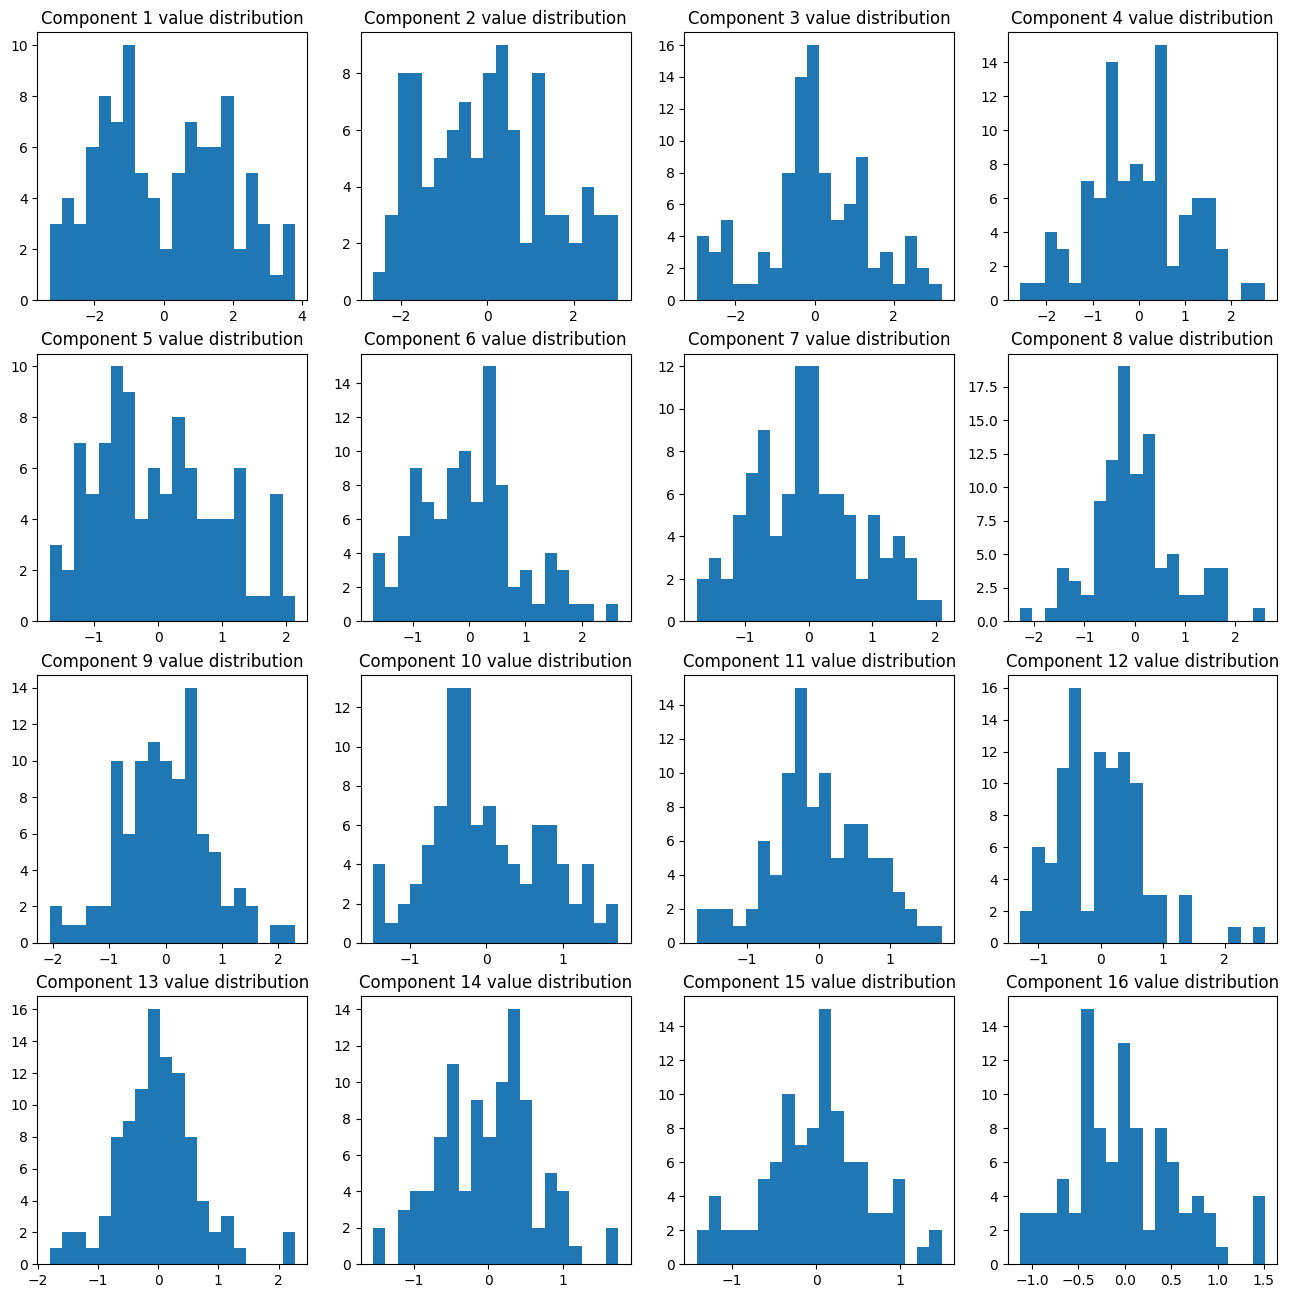

In [21]:
def plot_component_value_distributions(
        projections: np.ndarray, n_components: int, start_component: int = 0,
        panel_width: float = 4, panel_height: float = 4, bins: int = 10):
    largest_div = int(np.floor(n_components ** 0.5))
    while n_components % largest_div != 0:
        largest_div -= 1

    layout = (largest_div, n_components // largest_div)
    fig, axes = plt.subplots(*layout, figsize=(panel_width * layout[1], panel_height * layout[0]))

    for i in range(n_components):
        ax = axes[i // layout[1]][i % layout[1]]
        ax.hist(projections[:, i], bins=bins)
        ax.set_title(f'Component {i + 1 + start_component} value distribution')



projections = pca.transform(features_array)

plot_component_value_distributions(projections, 16, start_component=0, bins=20)

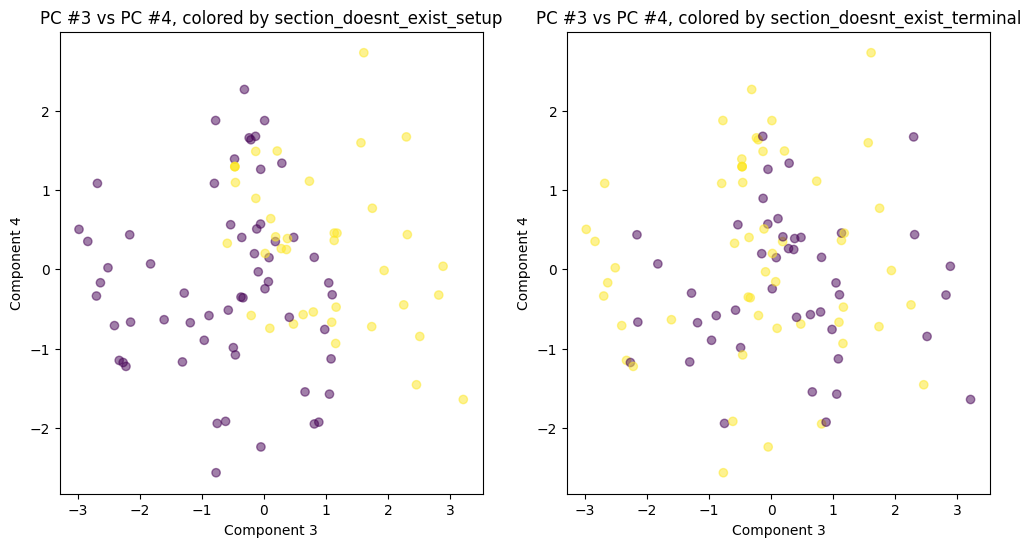

In [22]:
def scatter_plot_projection(
        projections: np.ndarray, feature_dicts: typing.List[typing.Dict[str, float]],
        x_component_index: int = 0, y_component_index: int = 1, color_by_key: typing.Optional[str | typing.List[str]] = None,
        cmap: str | typing.List[str] = 'viridis', panel_width: float = 6, panel_height: float = 6, 
):
    x = projections[:, x_component_index]
    y = projections[:, y_component_index]
    if color_by_key is not None:
        if isinstance(color_by_key, str):
            color_by_key = [color_by_key]
        
        color_lists = [[feature_dict[key] for feature_dict in feature_dicts] for key in color_by_key]
        titles = [f'PC #{x_component_index + 1} vs PC #{y_component_index + 1}, colored by {key}' for key in color_by_key]
    else:
        color_lists = [None]
        titles = [f'PC #{x_component_index + 1} vs PC #{y_component_index + 1}']

    if isinstance(cmap, str):
        cmap = [cmap] * len(color_lists)

    layout = (1, len(color_lists))
    fig, axes = plt.subplots(*layout, figsize=(panel_width * layout[1], panel_height * layout[0]))

    for i, (color, title, cmap) in enumerate(zip(color_lists, titles, cmap)):
        if isinstance(axes, plt.Axes):
            ax = axes
        else:
            ax = axes[i]

        ax.scatter(x, y, c=color, cmap=cmap, alpha=0.5)  # type: ignore
        ax.set_xlabel(f'Component {x_component_index + 1}')
        ax.set_ylabel(f'Component {y_component_index + 1}')
        ax.set_title(title)

    plt.show()


scatter_plot_projection(projections, feature_dicts, 2, 3, 
                        ['section_doesnt_exist_setup', 'section_doesnt_exist_terminal'])


## TODO from here

* Implement a class for a dimensionality reduction-based feature extractor
* Get the components required to convert ASTs to feature vectors (featurizer, feature names)
* Get the indices of the PCs to use for the feature vectors, and how many bins to quantize each to
* At runtime, accept a feature vector, and return a tuple of bins

In [24]:
umap_reducer = umap.UMAP(random_state=PCA_RANDOM_SEED)
umap_projections = umap_reducer.fit_transform(projections)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


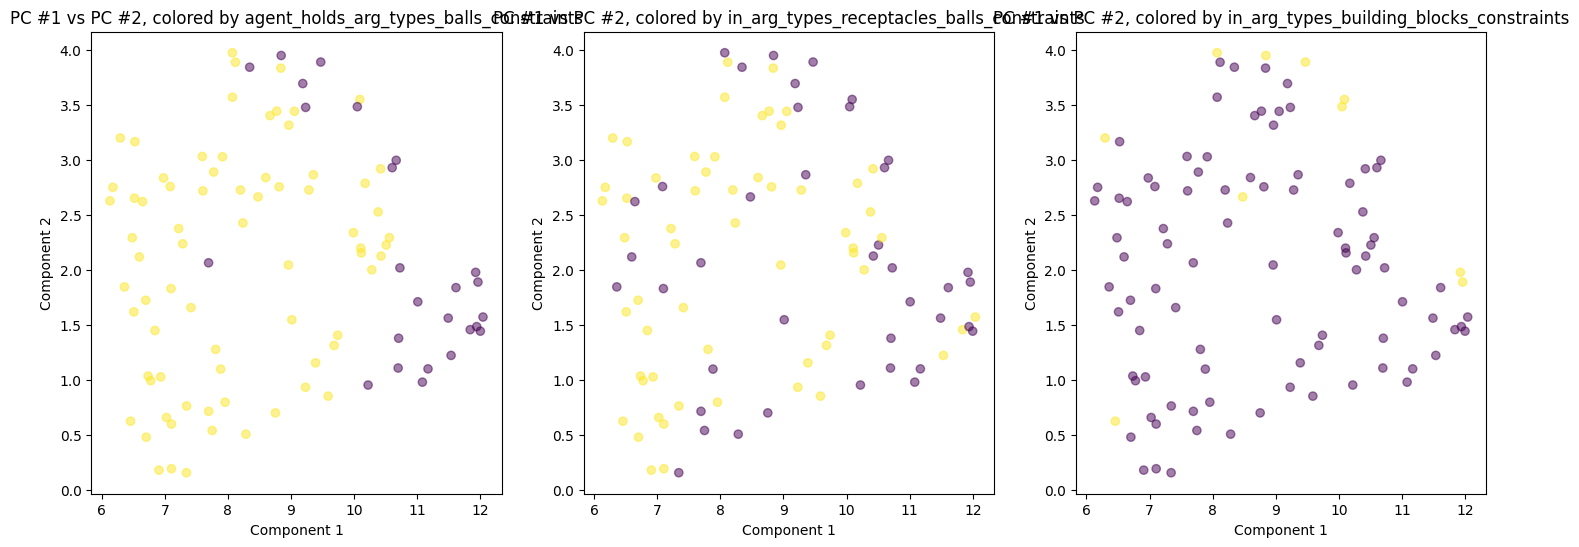

In [25]:
scatter_plot_projection(umap_projections, feature_dicts, 
                        color_by_key=['agent_holds_arg_types_balls_constraints', 'in_arg_types_receptacles_balls_constraints', 'in_arg_types_building_blocks_constraints'])


In [26]:
from collections import Counter

n = 4
values = umap_projections[:, 0]
step = 1 / n
quantiles = np.quantile(values, np.linspace(step, 1 - step, n - 1))
digits = np.digitize(values, quantiles)
counter = Counter(digits)
counter, min(counter), max(counter)


(Counter({1: 24, 0: 25, 3: 25, 2: 24}), 0, 3)

In [27]:
n = 5
step = 1 / n
np.linspace(step, 1 - step, n - 1)

array([0.2, 0.4, 0.6, 0.8])

In [28]:
quantiles

array([ 7.23543978,  8.70990515, 10.15854168])

In [29]:
np.digitize(10, quantiles)

2